# Set Up

In [186]:
# Import relevant libraries and such 
import sys
import os
import matplotlib
if 'matplotlib.pyplot' not in sys.modules.keys():
    matplotlib.use("Agg")
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, CubicSpline
# import propagation_lib as prop 

%matplotlib inline

## Constants ##
ft2m = 0.3048
c_speed = 3.0e8
kB = 1.39e-23

## Loading Trajectory + Receiving Site Information

In [181]:
# Trajectory path 
trajectoryrt = np.genfromtxt("Traj_Right.txt", skip_header=1, dtype=float)

# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arraysrt = {header: trajectoryrt[:, i] for i, header in enumerate(headers)}

for title, array in traj_arraysrt.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [182]:
# Same for left trajectory
trajectorylf = np.genfromtxt("Traj_Left.txt", skip_header=1, dtype=float)
# Read the header separately
with open('Traj_Right.txt', 'r') as file:
    headers = file.readline().strip().split()

# Create arrays for each column using the header titles
traj_arrayslf = {header: trajectorylf[:, i] for i, header in enumerate(headers)}

for title, array in traj_arrayslf.items():
    title = title + "_rttraj"
#     print(f"{title}: {array}")
# print(traj_arrays)

In [183]:
# Receiving sites -- from SDR document
# PF == poker flat
lat_pf = 65.1192
long_pf = -147.43

# VT == venetie
lat_vt = 67.013
long_vt = -146.407

# BV == beaver
lat_bv = 66.36
long_bv = -147.4

# AV == arctic village 
lat_av = 68.113
long_av = -147.575
# TL == toolik
lat_tl = 68.627
long_tl = -149.598

## Generate Rocket Position Function

In [184]:
import numpy as np

# Constants
R_EARTH = 6371000  # Earth radius in meters

# Convert spherical to Cartesian coordinates
def spherical_to_cartesian(r, theta, phi):
	x = r * np.sin(theta) * np.cos(phi)
	y = r * np.sin(theta) * np.sin(phi)
	z = r * np.cos(theta)
	return np.array([x, y, z])

# Convert Cartesian to spherical coordinates
def cartesian_to_spherical(x, y, z):
	r = np.sqrt(x**2 + y**2 + z**2)
	theta = np.arcsin(z / r)  # Polar angle
	phi = np.arctan2(y, x)    # Azimuthal angle
	return np.array([r, theta, phi])

# Translate a point in spherical coordinates relative to a reference point
def translate_point_spherical(r1, theta1, phi1, r2, theta2, phi2):
	# Convert reference point and satellite point to Cartesian
	p1_cartesian = spherical_to_cartesian(r1, theta1, phi1)
	p2_cartesian = spherical_to_cartesian(r2, theta2, phi2)
	# Calculate the translated Cartesian coordinates
	translated_cartesian = p2_cartesian - p1_cartesian
	# Convert back to spherical coordinates
	return cartesian_to_spherical(*translated_cartesian)



# Initialize arrays
radiipf, radiivt, thetaspf, thetasvt, phispf, phisvt, times = [], [], [], [], [], [], []
radiitl, thetastl, phistl = [], [], []
# Process trajectory data
for i, time in enumerate(traj_arraysrt["Time"]):
	latitude = traj_arraysrt["Latgd"][i]
	longitude = traj_arraysrt["Long"][i]
	altitude = traj_arraysrt["Altkm"][i] * 1000  # Convert altitude to meters
	time = traj_arraysrt["Time"][i]
	
	# Poker Flat as origin
	rpf, tpf, ppf = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_pf), np.radians(long_pf),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiipf.append(rpf)
	thetaspf.append(np.degrees(np.arccos(altitude/rpf)))
	ppf = np.degrees(ppf)
	if ppf < 0:
		ppf += 180
	
	phispf.append(ppf)
	
	# Venetie as origin
	rvt, tvt, pvt = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_vt), np.radians(long_vt),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiivt.append(rvt)
	thetasvt.append(np.degrees(np.arccos(altitude/rvt)))
	pvt = np.degrees(pvt)
	if pvt < 0:
		pvt += 360
	phisvt.append(pvt)
	times.append(time)
	# Toolik as origin
	rtl, ttl, ptl = translate_point_spherical(
	    R_EARTH, np.pi/2 - np.radians(lat_tl), np.radians(long_tl),
	    R_EARTH + altitude, np.pi/2 - np.radians(latitude), np.radians(longitude)
	)
	radiitl.append(rtl)
	thetastl.append(np.degrees(np.arccos(altitude/rtl)))
	ptl = np.degrees(ptl)
	if ptl < 0:
		ptl += 360
	phistl.append(ptl)

# Link Margin Calculator

## NEC2 Gain Interpolation

In [6]:
import pandas as pd
from scipy.interpolate import RBFInterpolator as rbf
#documentation for interpolator - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RBFInterpolator.html#scipy.interpolate.RBFInterpolator
# Get NEC data from excel spreadsheet
def data_from_excel(sheet_name):
	signal_data = pd.read_excel(sheet_name)
	# convert angle scales to match traj data
	signal_data['THETA']=signal_data['THETA'].abs()
	# convert complete loss value to avoid screwing up the interpolation
	signal_data.loc[signal_data['TOTAL']<=-900, 'TOTAL']=-20
	return(signal_data)

#rotate phi 90 degrees for N-S antenna
def rotate(signal_data):
	rotated_df = signal_data.copy()
	rotated_df['PHI'] = rotated_df['PHI'].apply(lambda x: x+90 if x<270 else x-270)
	return rotated_df
# Get interpolated function with Radial Basis Function 
def rbf_nec_data(signal_data):
	theta_vals = signal_data[['THETA']].to_numpy().flatten()
	phi_vals = signal_data[['PHI']].to_numpy().flatten()
	totals = signal_data['TOTAL'].to_numpy()
	interp = rbf(list(zip(theta_vals, phi_vals)), totals)
	return lambda thet, ph: interp(np.array([[thet, ph]])).item()
#interpolate trajectory data



nec_data = data_from_excel('10152024_nec_data.xlsx')
ht15_nec_data = data_from_excel('15height_nec_data.xlsx')
ht2_nec_data = data_from_excel('2height_nec_data.xlsx')
# interpolate function from NEC data
rbf_f = rbf_nec_data(nec_data)
ht15_f = rbf_nec_data(ht15_nec_data)
ht2_f = rbf_nec_data(ht2_nec_data)

# gain calculations
vt_rbf = []
pf_rbf = []
tl_rbf = []
vt_ht15 = []
pf_ht15 = []
tl_ht15 = []
vt_ht2 = []
pf_ht2 = []
tl_ht2 = []

#fix thetaspf
fixed_thetaspf=thetaspf.copy()
for i in range(np.argmin(fixed_thetaspf)):
	fixed_thetaspf[i]=np.nan

for phi, theta in zip(phisvt, thetasvt):
	vtr = rbf_f(theta, phi)
	vt_rbf.append(vtr)
	vt_ht15.append(ht15_f(theta, phi))
	vt_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phispf, fixed_thetaspf):
	pfr = rbf_f(theta, phi)
	pf_rbf.append(pfr)
	pf_ht15.append(ht15_f(theta, phi))
	pf_ht2.append(ht2_f(theta, phi))
for phi, theta in zip(phistl, thetastl):
	tlr = rbf_f(theta, phi)
	tl_rbf.append(tlr)
	tl_ht15.append(ht15_f(theta, phi))
	tl_ht2.append(ht2_f(theta, phi))


### Interpolation Contour Plot

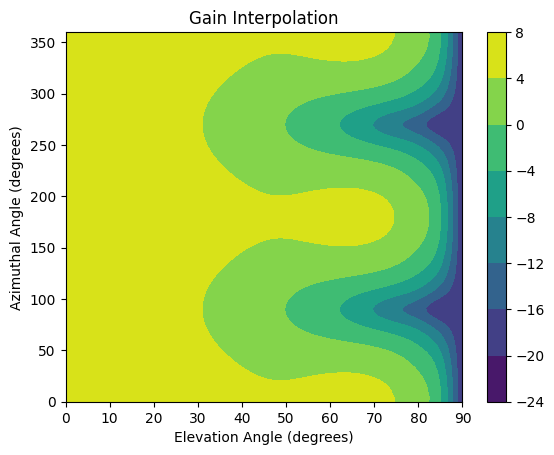

In [15]:
theta_vals = nec_data[['THETA']].to_numpy().flatten()
phi_vals = nec_data[['PHI']].to_numpy().flatten()
totals = nec_data['TOTAL'].to_numpy()

from scipy.interpolate import RBFInterpolator as rbf
rbf_func = rbf(list(zip(theta_vals, phi_vals)), totals)
X = np.linspace(min(theta_vals), max(theta_vals), 100)
Y = np.linspace(min(phi_vals), max(phi_vals), 100)
X, Y = np.meshgrid(X, Y)
grid_points = np.c_[X.ravel(), Y.ravel()]
Z2 = rbf_func(grid_points)

# Reshape Z2 to the shape of X and Y
Z2 = Z2.reshape(X.shape)
plt.contourf(X, Y, Z2)
plt.colorbar()
plt.xlabel('Elevation Angle (degrees)')
plt.ylabel('Azimuthal Angle (degrees)')
plt.title('Gain Interpolation')
plt.show()



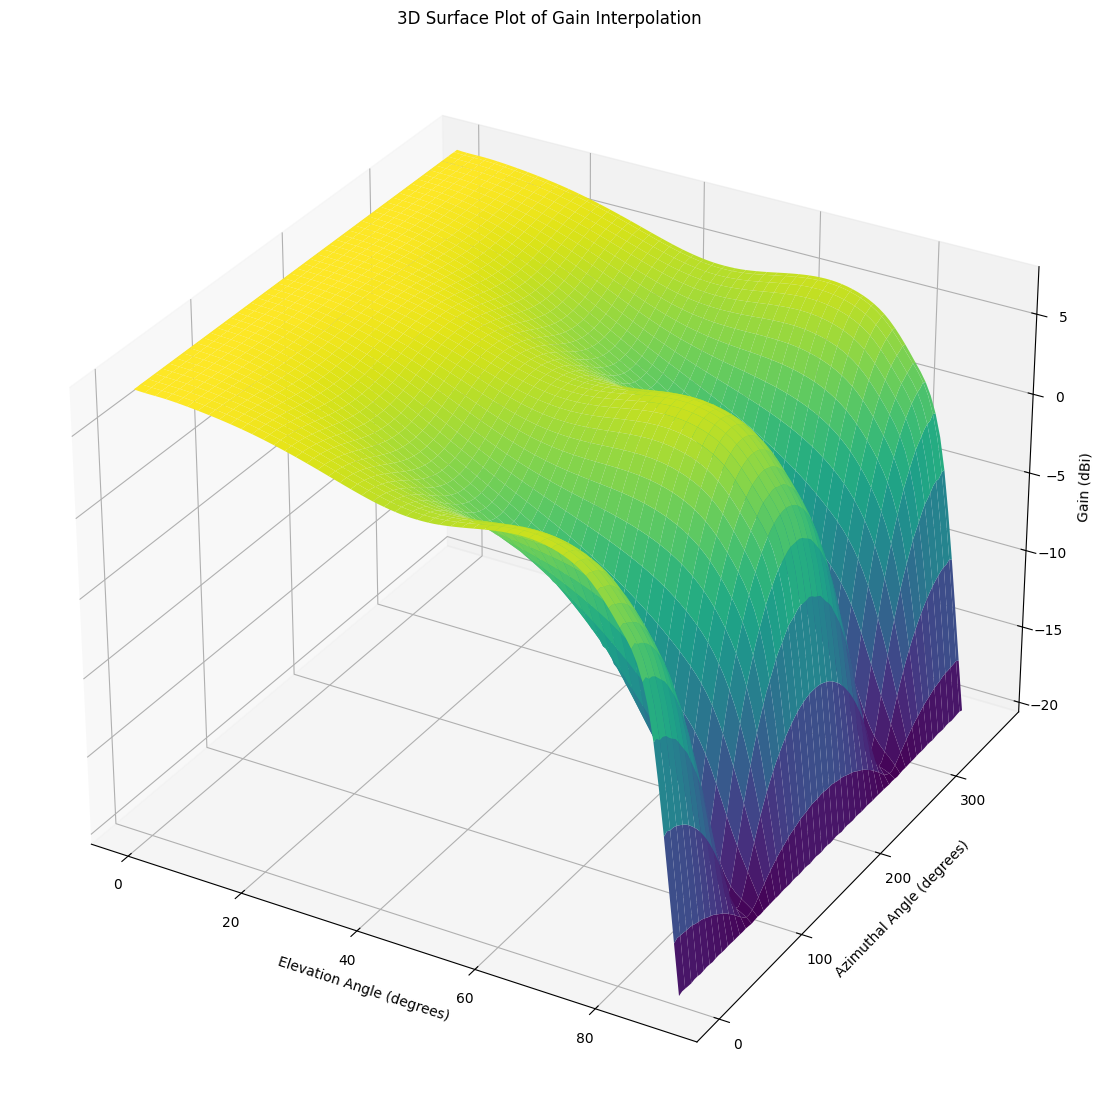

In [340]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z2, cmap='viridis')
ax.set_xlabel('Elevation Angle (degrees)')
ax.set_ylabel('Azimuthal Angle (degrees)')
ax.set_zlabel('Gain (dBi)')
plt.locator_params(axis='y', nbins=4)
plt.title('3D Surface Plot of Gain Interpolation')
plt.show()

## Polarization Loss

### Define Position Matrices

In [163]:
# define rocket position function as numpy matrix for each site
r_vt = np.array([radiivt, thetasvt, phisvt]).T
r_pf = np.array([radiipf, thetaspf, phispf]).T
r_tl = np.array([radiitl, thetastl, phistl]).T

r_vt[:,1] = np.radians(r_vt[:,1])
r_vt[:,2] = np.radians(r_vt[:,2])
r_pf[:,1] = np.radians(r_pf[:,1])
r_pf[:,2] = np.radians(r_pf[:,2])
r_tl[:,1] = np.radians(r_tl[:,1])
r_tl[:,2] = np.radians(r_tl[:,2])

spin_rate = 2
r_whip = np.empty((len(times), 3))
r_whip[:,0] = 1
r_whip[:,1] = np.pi/2
r_whip[:,2] = spin_rate*np.array(times)

#get numpy version of times
times_np = np.array(times)


### Polarization Loss Calculator

In [176]:
# convert numpy vector from spherical to cartesian coordinates
def s_c_vec_conversion(spherical_vec):
    x = spherical_vec[0] * np.sin(np.radians(spherical_vec[1])) * np.cos(np.radians(spherical_vec[2]))
    y = spherical_vec[0] * np.sin(np.radians(spherical_vec[1])) * np.sin(np.radians(spherical_vec[2]))
    z = spherical_vec[0] * np.cos(np.radians(spherical_vec[1]))
    return np.array([x, y, z])

# clip the dot product to avoid floating point errors. assumes normalized vectors
def clip_norm_dots(vec1, vec2):
     return np.clip(np.dot(vec1, vec2),0,0.9999)

# rec_orientation: 0=EW, 1=NS. Defining cartesian plane along receiver axes.
def general_polarization_loss(rocket_pos, whip_pos, rec_orientation):
    if rec_orientation == 0:
        l1_hat = np.array([1, 0, 0])
    elif rec_orientation == 1:
        l1_hat = np.array([1,0,np.pi/2])/np.linalg.norm(np.array([1,0,np.pi/2]))
    else:
        raise ValueError("Receive orientation parameter must be 0 or 1")

    whip_pos_adjusted = np.add(rocket_pos, whip_pos)
    l2_hat = s_c_vec_conversion(whip_pos_adjusted)/np.linalg.norm(s_c_vec_conversion(whip_pos_adjusted))
    r_hat = s_c_vec_conversion(rocket_pos)/np.linalg.norm(s_c_vec_conversion(rocket_pos))
    dot_l1_r = clip_norm_dots(l1_hat, r_hat)
    dot_l2_r = clip_norm_dots(l2_hat, r_hat)
    dot_l1_l2 = clip_norm_dots(l1_hat, l2_hat)

    loss = (dot_l1_l2 - (dot_l1_r*dot_l2_r))/(np.sqrt(1-dot_l1_r**2)*np.sqrt(1-dot_l2_r**2))
    return loss

In [167]:
# Calculate polarization losses for each site
vt_pol_loss_EW = []
pf_pol_loss_EW = []
tl_pol_loss_EW = []
vt_pol_loss_NS = []
pf_pol_loss_NS = []
tl_pol_loss_NS = []

for r, whip in zip(r_vt, r_whip):
	vt_pol_loss_EW.append(general_polarization_loss(r,whip,0))
for r, whip in zip(r_pf, r_whip):
	pf_pol_loss_EW.append(general_polarization_loss(r,whip,0))
for r, whip in zip(r_tl, r_whip):
	tl_pol_loss_EW.append(general_polarization_loss(r,whip,0))

for r, whip in zip(r_vt, r_whip):
	vt_pol_loss_NS.append(general_polarization_loss(r,whip,1))
for r, whip in zip(r_pf, r_whip):
	pf_pol_loss_NS.append(general_polarization_loss(r,whip,1))
for r, whip in zip(r_tl, r_whip):
	tl_pol_loss_NS.append(general_polarization_loss(r,whip,1))

### Signal Strength Calculator

In [172]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

def calc_received_power(radii, gains, ploss):
	result = []
	for radius, gain, pol_loss in zip(radii, gains, ploss):
		txPwr = 1.5  

		# Path loss calculation
		Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

		# Received power calculation in Watts

		Pwr_rx = (txPwr * Gtx * gain*(pol_loss**2)) / Lpath
		if Pwr_rx <= 0:
			Pwr_rx = 1e-100
		Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
		# Append the calculated power to the list, converting to dbm
		result.append(Pwr_rx_dBW+30)
	return result

### Signal Plots

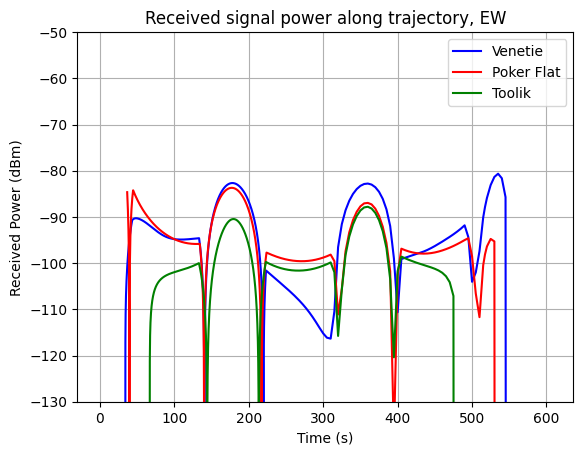

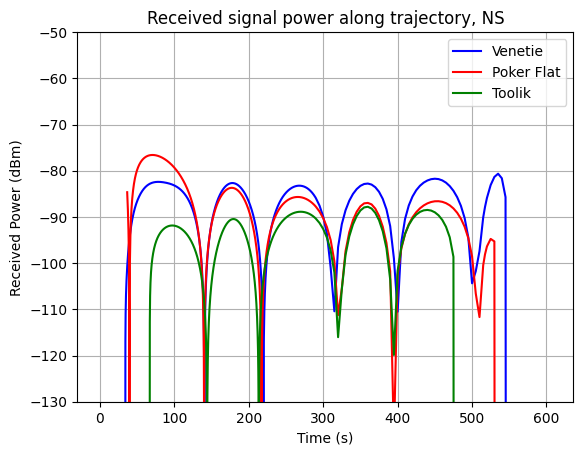

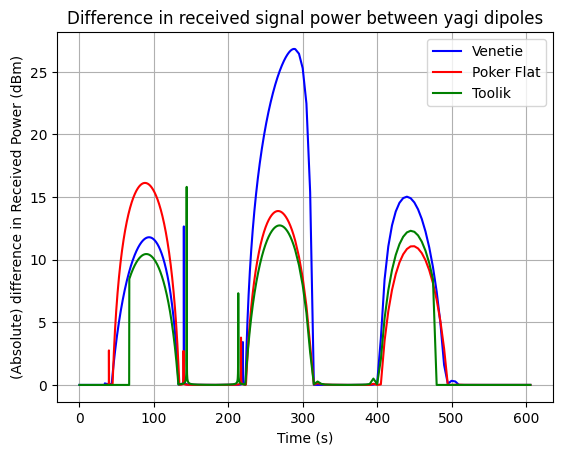

In [ ]:
receivedpowervt_EW = calc_received_power(radiivt, vt_rbf, vt_pol_loss_EW)
receivedpowerpf_EW = calc_received_power(radiipf, pf_rbf, pf_pol_loss_EW)
receivedpowertl_EW = calc_received_power(radiitl, tl_rbf, tl_pol_loss_EW)
receivvedpowervt_NS = calc_received_power(radiivt, vt_rbf, vt_pol_loss_NS)
receivedpowerpf_NS = calc_received_power(radiipf, pf_rbf, pf_pol_loss_NS)
receivedpowertl_NS = calc_received_power(radiitl, tl_rbf, tl_pol_loss_NS)

#plot EW antenna signal
plt.plot(times, receivedpowervt_EW, color='blue')
plt.plot(times, receivedpowerpf_EW, color='red')
plt.plot(times, receivedpowertl_EW, color='green')


plt.title("Received signal power along trajectory, EW")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True) 
plt.show()


#plot NS antenna signal
plt.plot(times, receivvedpowervt_NS, color='blue')
plt.plot(times, receivedpowerpf_NS, color='red')
plt.plot(times, receivedpowertl_NS, color='green')

plt.title("Received signal power along trajectory, NS")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.ylim(-130, -50)
plt.grid(True)
plt.show()

#plot signal difference
signal_diff_vt = np.abs(np.subtract(receivedpowervt_EW, receivvedpowervt_NS))
signal_diff_pf = np.abs(np.subtract(receivedpowerpf_EW, receivedpowerpf_NS))
signal_diff_tl = np.abs(np.subtract(receivedpowertl_EW, receivedpowertl_NS))
plt.plot(times, signal_diff_vt, color='blue')
plt.plot(times, signal_diff_pf, color='red')
plt.plot(times, signal_diff_tl, color='green')
plt.title("Difference in received signal power between yagi dipoles")
plt.xlabel("Time (s)")
plt.ylabel("(Absolute) difference in Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)
plt.show()


In [199]:
# Data
signif_vt = np.where(signal_diff_vt > 0.5)[0]
signif_pf = np.where(signal_diff_pf > 0.5)[0]
signif_tl = np.where(signal_diff_tl > 0.5)[0]
print(len(signif_vt)/len(signal_diff_vt))
print(len(signif_pf)/len(signal_diff_pf))
print(len(signif_tl)/len(signal_diff_tl))

0.5344306348673161
0.5310715485387975
0.4608666442727578


# Reference/Archive

### Coordinate Plots

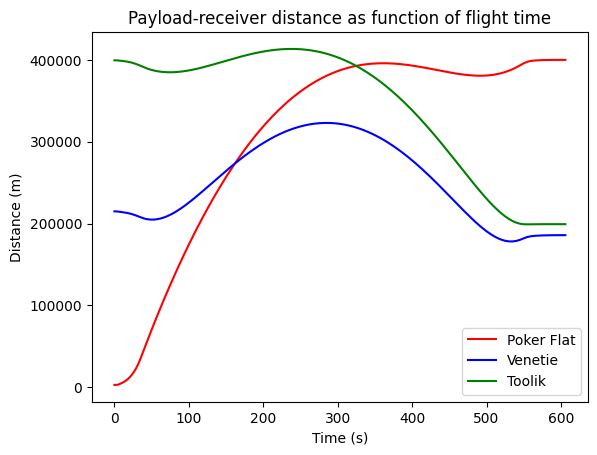

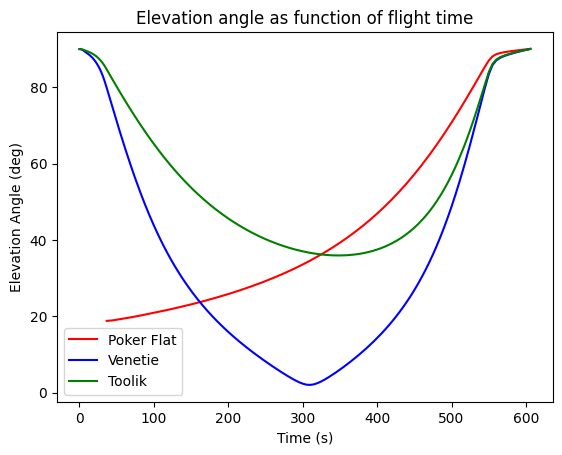

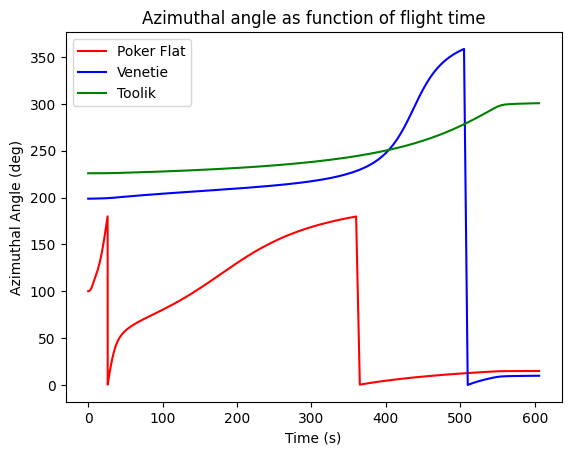

In [187]:
# Radius vs time
plt.plot(times, radiipf, label='Poker Flat', color='red')
plt.plot(times, radiivt, label='Venetie', color='blue')
plt.plot(times, radiitl, label='Toolik', color='green')
plt.title("Payload-receiver distance as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.legend()
plt.show()
# Elevation angle vs time
plt.plot(times, fixed_thetaspf, label='Poker Flat', color='red')
plt.plot(times, thetasvt, label='Venetie', color='blue')
plt.plot(times, thetastl, label='Toolik', color='green')
plt.title("Elevation angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Elevation Angle (deg)")
plt.legend()
plt.show()
# Azimuthal angle vs time
plt.plot(times, phispf, label='Poker Flat', color='red')
plt.plot(times, phisvt, label='Venetie', color='blue')
plt.plot(times, phistl, label='Toolik', color='green')
plt.title("Azimuthal angle as function of flight time")
plt.xlabel("Time (s)")
plt.ylabel("Azimuthal Angle (deg)")
plt.legend()
plt.show()


### Angular Dependence

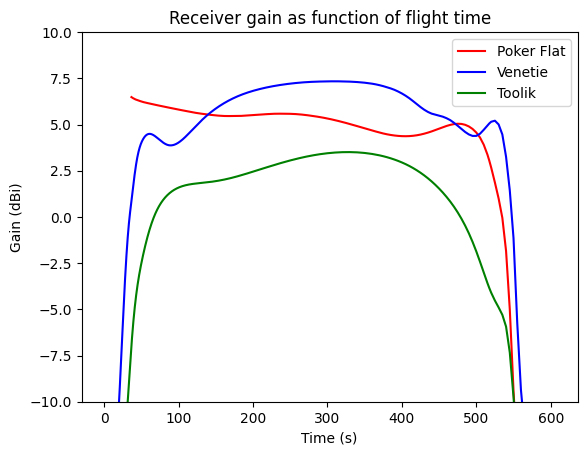

In [188]:
# Gain, angular dependence only
plt.plot(times, pf_rbf, label='Poker Flat', color='red')
plt.plot(times, vt_rbf, label='Venetie', color='blue')
plt.plot(times, tl_rbf, label='Toolik', color='green')
plt.xlabel('Time (s)')
plt.ylabel('Gain (dBi)')
plt.ylim(-10,10)
plt.title('Receiver gain as function of flight time')
plt.legend()
plt.show()

### Radial Dependence

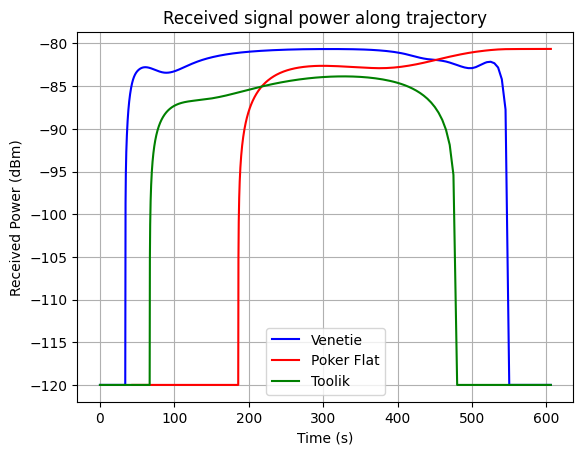

In [346]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant
r = 240000
receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm
receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * r * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)
#TEMP - remove signal jump at beginning of Poker Flat
# plot received power against trajectory
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

In [90]:
print(np.argmin(thetaspf))

373


### Radial and Angular Dependence

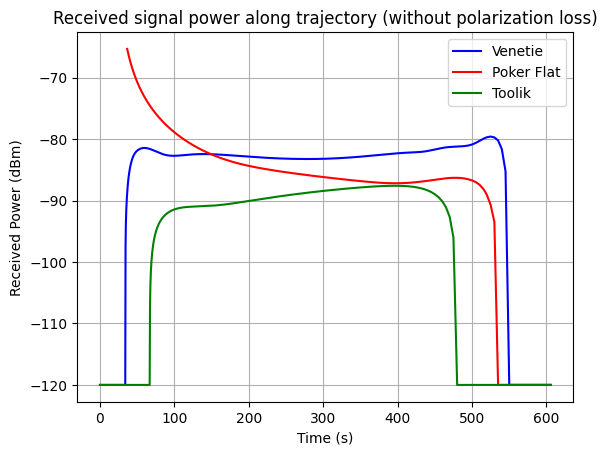

In [49]:
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

receivedpowervt = []
for radius, gain in zip(radiivt, vt_rbf):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowervt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowerpf = []
for radius, gain in zip(radiipf, pf_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowerpf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

receivedpowertl = []
for radius, gain in zip(radiitl, tl_rbf):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    receivedpowertl.append(Pwr_rx_dBW+30)

#TEMP - remove signal jump at beginning of Poker Flat
for i in range(np.argmin(receivedpowerpf)):
    receivedpowerpf[i] = np.nan

#plot received power along trajectory
plt.plot(times, receivedpowervt, color='blue')
plt.plot(times, receivedpowerpf, color='red')
plt.plot(times, receivedpowertl, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory (without polarization loss)")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"])
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()

### Height Comparisons

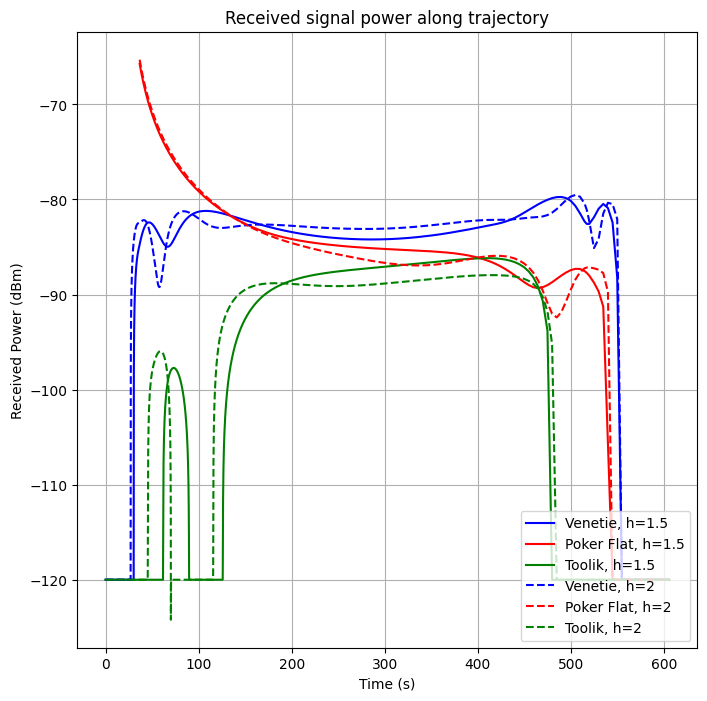

In [ ]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt = []
for radius, gain in zip(radiivt, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15pf = []
for radius, gain in zip(radiipf, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
for radius, gain in zip(radiitl, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)


#ht=2
ht2vt = []
for radius, gain in zip(radiivt, vt_ht2):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2vt.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2pf = []
for radius, gain in zip(radiipf, pf_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2pf.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht2tl = []
for radius, gain in zip(radiitl, tl_ht2):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht2tl.append(Pwr_rx_dBW+30)

plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht2vt, color='blue', linestyle='--')
plt.plot(times, ht2pf, color='red', linestyle='--')
plt.plot(times, ht2tl, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, h=1.5", "Poker Flat, h=1.5", "Toolik, h=1.5", "Venetie, h=2", "Poker Flat, h=2", "Toolik, h=2"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### NS Height Comparison

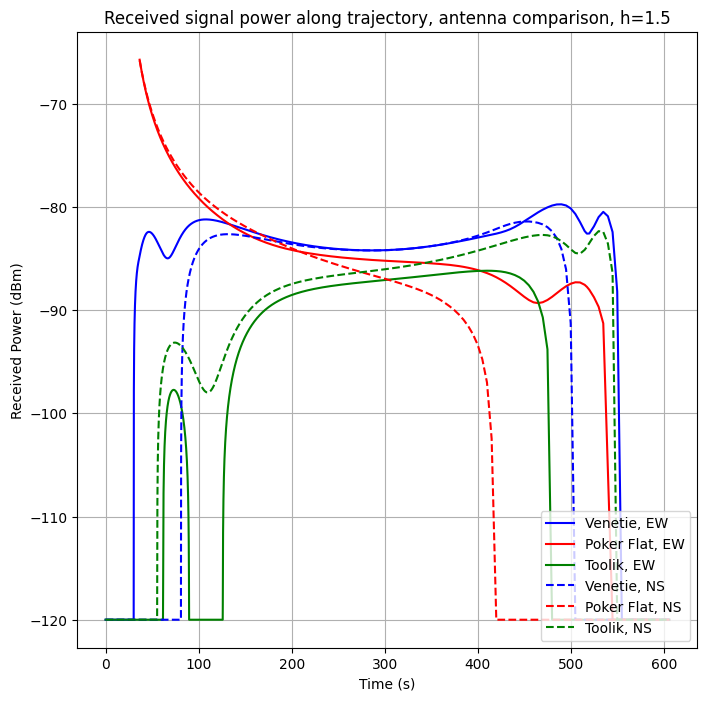

In [120]:
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)



plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, ht15vt, color='blue')
plt.plot(times, ht15pf, color='red')
plt.plot(times, ht15tl, color='green')
plt.plot(times, ht15vt_rotated, color='blue', linestyle='--')
plt.plot(times, ht15pf_rotated, color='red', linestyle='--')
plt.plot(times, ht15tl_rotated, color='green', linestyle='--')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Received signal power along trajectory, antenna comparison, h=1.5")
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dBm)")
plt.legend(["Venetie, EW", "Poker Flat, EW", "Toolik, EW", "Venetie, NS", "Poker Flat, NS", "Toolik, NS"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Antenna Difference

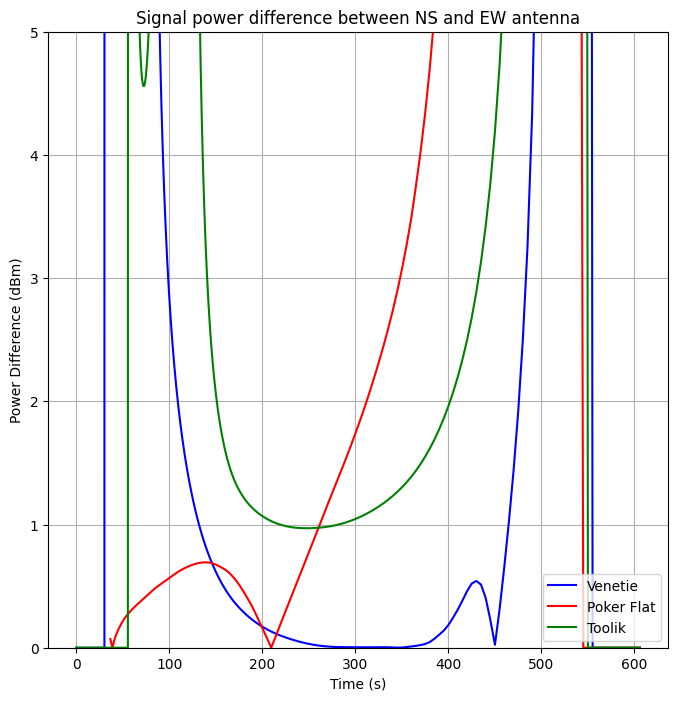

In [56]:
# Plotting difference between antenna orientations signal
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)


tldiff = []
pfdiff = []
vtdiff = []
for tl, pf, vt, tlrot, pfrot, vtrot in zip(ht15tl, ht15pf, ht15vt, ht15tl_rotated, ht15pf_rotated, ht15vt_rotated):
	tldiff.append(np.abs(tl-tlrot))
	pfdiff.append(np.abs(pf-pfrot))
	vtdiff.append(np.abs(vt-vtrot))
    
plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, vtdiff, color='blue')
plt.plot(times, pfdiff, color='red')
plt.plot(times, tldiff, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Signal power difference between NS and EW antenna")
plt.xlabel("Time (s)")
plt.ylabel("Power Difference (dBm)")
plt.ylim(0,5)
plt.legend(["Venetie", "Poker Flat", "Toolik"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Antenna Ratio

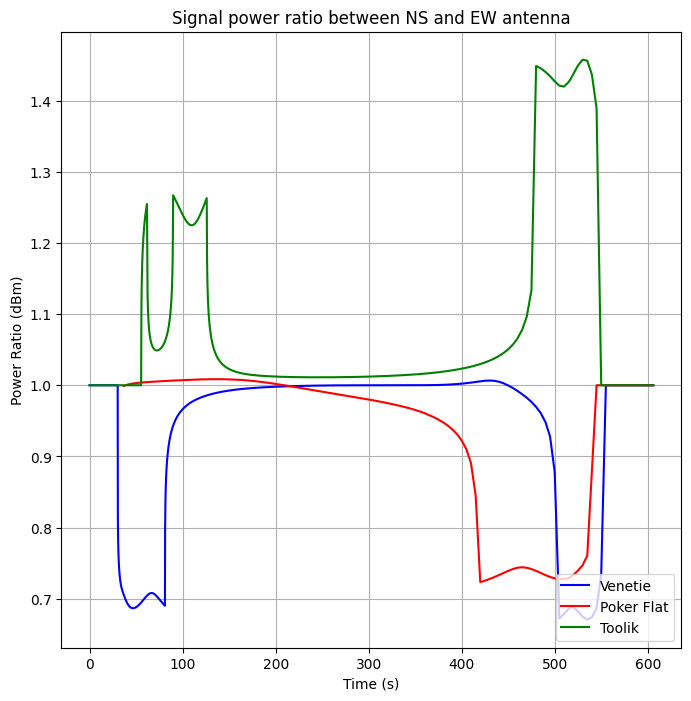

In [14]:
# Plotting ratio between antenna orientations signal
%matplotlib inline
# Constants
freq = 162.990625e6  # transmit frequency (Hz)
Gtx = 2.1  # dBi for transmitter gain
Bn = 20e3  # Bandwidth
NFrx_dB = 0.5  # Noise figure in dB with a pre-amp
NFrx = 10.0 ** (NFrx_dB / 10)  # Convert to dimensionless quantity
c_speed = 3.0e8  # Speed of light in m/s
kB = 1.38e-23  # Boltzmann constant

ht15vt_rotated = []
ht15vt = []
for radius, rotated_gain, gain in zip(radiivt, vt_rotated_ht15, vt_ht15):
    
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts

    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15vt_rotated.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15vt.append(Pwr_rx_dBW+30)

ht15pf = []
ht15pf_rotated = []
for radius, rotated_gain, gain in zip(radiipf, pf_rotated_ht15, pf_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15pf.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15pf_rotated.append(Pwr_rx_dBW+30)

    # Append the calculated power to the list, converting to dbm

ht15tl = []
ht15tl_rotated = []
for radius, rotated_gain, gain in zip(radiitl, tl_rotated_ht15, tl_ht15):
    # Transmit power (using a constant value of 1.5 for this plot)
    txPwr = 1.5  

    # Path loss calculation
    Lpath = (4.0 * np.pi * radius * freq / c_speed) ** 2

    # Received power calculation in Watts
    Pwr_rx = (txPwr * Gtx * gain) / Lpath
    if(Pwr_rx <= 0):
        Pwr_rx=1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)

    # Append the calculated power to the list, converting to dbm
    ht15tl.append(Pwr_rx_dBW+30)
    Pwr_rx = (txPwr * Gtx * rotated_gain) / Lpath
    if Pwr_rx <= 0:
        Pwr_rx = 1e-15
    Pwr_rx_dBW = 10 * np.log10(Pwr_rx)
    ht15tl_rotated.append(Pwr_rx_dBW+30)


tlratio = []
pfratio = []
vtratio = []
for tl, pf, vt, tlrot, pfrot, vtrot in zip(ht15tl, ht15pf, ht15vt, ht15tl_rotated, ht15pf_rotated, ht15vt_rotated):
	tlratio.append(np.abs(tl/tlrot))
	pfratio.append(np.abs(pf/pfrot))
	vtratio.append(np.abs(vt/vtrot))
    
plt.figure(figsize=(8,8))
#plot received power along trajectory
plt.plot(times, vtratio, color='blue')
plt.plot(times, pfratio, color='red')
plt.plot(times, tlratio, color='green')

# Labels for the plot
#plt.ylim(-130, -50)
#plt.axhline(y=-107, color='gray', linestyle='--')
#plt.axhline(y=-67, color='gray', linestyle='--')
plt.title("Signal power ratio between NS and EW antenna")
plt.xlabel("Time (s)")
plt.ylabel("Power Ratio (dBm)")
plt.legend(["Venetie", "Poker Flat", "Toolik"],loc='lower right')
plt.grid(True)  # Adding grid for better visualization

# Display the plot
plt.show()


### Adding Rocket Rotation

2.1
1.1


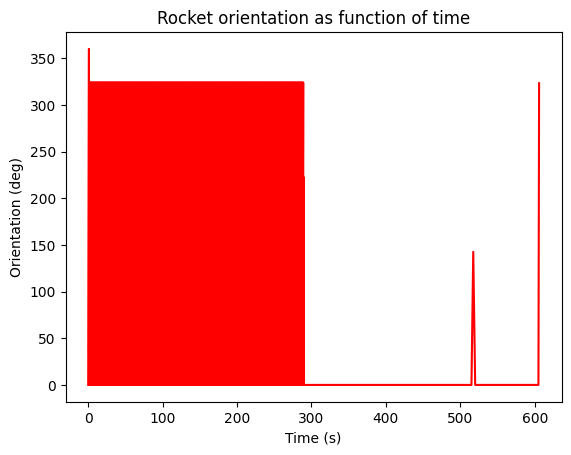

In [ ]:
def get_rocket_angles(frequency):
	first = True
	angvel = 360*frequency # deg/s
	rocketori = 0
	angles = []
	for i in range(len(times)):
		if times[i]*angvel>360:
			if first:
				print(times[i])
				first=False
			angles.append((times[i]*angvel)%360)
		else:
			rocketori = angvel*times[i]
			angles.append(rocketori)

	return angles

freq_rocket = 0.5 # Hz
rocket_angles_half = get_rocket_angles(0.5)
rocket_angles_one = get_rocket_angles(1)


plt.plot(times, rocket_angles_one, color='red')
#plt.scatter(times, rocket_angles_one, color='blue')
plt.title("Rocket orientation as function of time")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (deg)")
#plt.show()

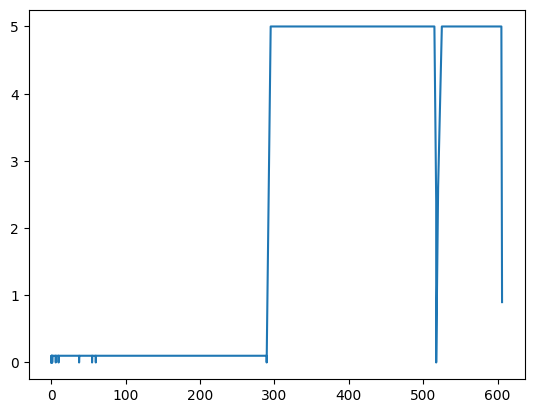

In [ ]:
#should just interpolate data out to like ten samples per spin
#note that the misalignment angle has to be a solid angle, where only one of the angles is spinning
timediffs = []
for i in range(len(times)-1):
	timediffs.append(times[i+1]-times[i])
timediffs.insert(0,0)
plt.plot(times, timediffs)

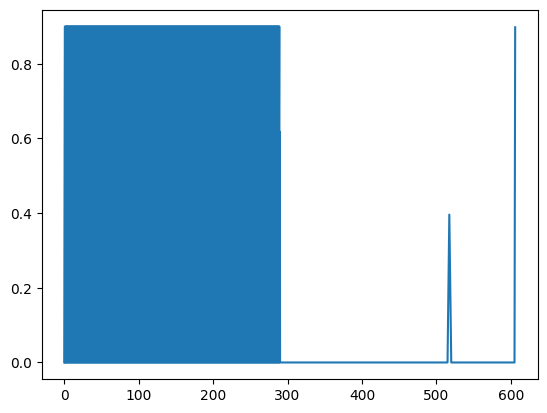

In [50]:
timedec = []
for i in range(len(times)):
	timedec.append(times[i]-np.floor(times[i]))
plt.plot(times, timedec)

[np.float64(0.0), np.float64(0.1), np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.622), np.float64(0.622), np.float64(0.7)]
[np.float64(565.0), np.float64(570.0), np.float64(575.0), np.float64(580.0), np.float64(585.0), np.float64(590.0), np.float64(595.0), np.float64(600.0), np.float64(605.0), np.float64(605.898)]


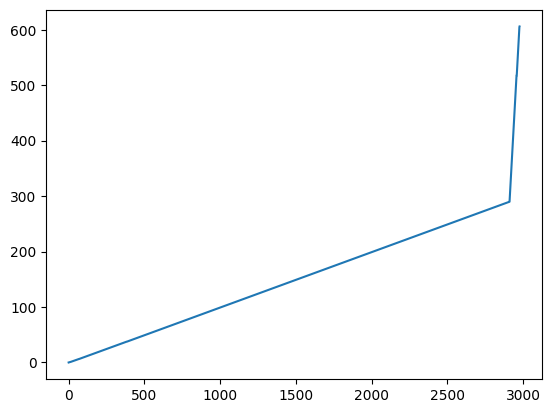

In [54]:
np.linspace(0,len(times),len(times))
plt.plot(np.linspace(0,len(times),len(times)), times)
print(times[0:10])
print(times[len(times)-10:len(times)])